# Causal Inference

In [1]:
#Installing libraries and packages

In [2]:
pip install dowhy

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge dowhy

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Nupur\anaconda3


  added / updated specs:
    - dowhy


The following packages will be SUPERSEDED by a higher-priority channel:

  conda               pkgs/main::conda-4.9.2-py38haa95532_0 --> conda-forge::conda-4.9.2-py38haa244fe_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [4]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [5]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
import dowhy.api
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [6]:
clv = pd.read_csv(r"C:\Users\Nupur\OneDrive - McGill University\Desktop\McGill Notes\INSY695075\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

In [7]:
clv_clean = clv.drop(columns=["Customer","Effective To Date","Policy Type"])

In [8]:
clv_clean.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,...,32,5,0,1,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,...,13,42,0,8,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,...,18,38,0,2,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,...,18,65,0,7,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,No,Basic,Bachelor,Employed,M,43836,Rural,Single,...,12,44,0,1,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [9]:
clv.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Customer             9134
State                   5
Response                2
Coverage                3
Education               5
Effective To Date      59
EmploymentStatus        5
Gender                  2
Location Code           3
Marital Status          3
Policy Type             3
Policy                  9
Renew Offer Type        4
Sales Channel           4
Vehicle Class           6
Vehicle Size            3
dtype: int64

In [10]:
#Splitting Features into binary and remaining categorical

binary_feature = clv_clean.nunique()[clv_clean.nunique() == 2].keys().tolist()

In [11]:
categorical_feature = [col for col in clv_clean.select_dtypes('object').columns.to_list() if col not in binary_feature]

In [12]:
categorical_feature

['State',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Location Code',
 'Marital Status',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Vehicle Class',
 'Vehicle Size']

In [13]:
# Feature Engineering  - dummyfying the binary and categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in binary_feature:
    clv_clean[i] = le.fit_transform(clv_clean[i])

In [14]:
clv_clean.columns

Index(['State', 'Customer Lifetime Value', 'Response', 'Coverage', 'Education',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy', 'Renew Offer Type', 'Sales Channel',
       'Total Claim Amount', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [15]:
clv_clean.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,0,Basic,Bachelor,Employed,0,56274,Suburban,Married,...,32,5,0,1,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,0,Extended,Bachelor,Unemployed,0,0,Suburban,Single,...,13,42,0,8,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,0,Premium,Bachelor,Employed,0,48767,Suburban,Married,...,18,38,0,2,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,0,Basic,Bachelor,Unemployed,1,0,Suburban,Married,...,18,65,0,7,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,0,Basic,Bachelor,Employed,1,43836,Rural,Single,...,12,44,0,1,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


**Creating Causal Models with Treatment and control features and target variable**

**Treatment - Gender**

In [16]:
clv_clean['Gender'] = clv_clean['Gender'].apply(bool)
clv_clean['Response'] = clv_clean['Response'].apply(bool)

In [17]:
clv_clean['EmploymentStatus'] = clv_clean['EmploymentStatus'].apply(lambda x: 1 if x=='Retired' else 0)

In [18]:
clv_clean['Renew Offer Type'] = clv_clean['Renew Offer Type'].apply(lambda x: 1 if x=='Offer2' else 0)

In [28]:
clv_clean['Coverage'] = clv_clean['Coverage'].apply(lambda x: 1 if x=='Basic' else 0)

In [29]:
clv_clean.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,propensity_score,strata,dbar,d_y,dbar_y
0,Washington,2763.519279,False,1,Bachelor,False,False,56274,Suburban,Married,...,False,Agent,384.811147,Two-Door Car,Medsize,0.456835,46.0,1,False,0
1,Arizona,6979.535903,False,0,Bachelor,False,False,0,Suburban,Single,...,False,Agent,1131.464935,Four-Door Car,Medsize,0.233869,7.0,1,False,0
2,Nevada,12887.431650,False,0,Bachelor,False,False,48767,Suburban,Married,...,False,Agent,566.472247,Two-Door Car,Medsize,0.339325,27.0,1,False,0
3,California,7645.861827,False,1,Bachelor,False,True,0,Suburban,Married,...,False,Call Center,529.881344,SUV,Medsize,0.185916,3.0,1,False,0
4,Washington,2813.692575,False,1,Bachelor,False,True,43836,Rural,Single,...,False,Agent,138.130879,Four-Door Car,Medsize,0.394712,38.0,1,False,0


In [30]:
clv_clean['EmploymentStatus'] = clv_clean['EmploymentStatus'].apply(bool)
clv_clean['Renew Offer Type'] = clv_clean['Renew Offer Type'].apply(bool)
clv_clean['Coverage'] = clv_clean['Coverage'].apply(bool)

In [31]:
clv_clean.dtypes

State                             object
Customer Lifetime Value          float64
Response                            bool
Coverage                            bool
Education                         object
EmploymentStatus                    bool
Gender                              bool
Income                             int64
Location Code                     object
Marital Status                    object
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Policy                            object
Renew Offer Type                    bool
Sales Channel                     object
Total Claim Amount               float64
Vehicle Class                     object
Vehicle Size                      object
propensity_score                 float64
strata                           float64
dbar                               int32
d_y             

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Gender'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


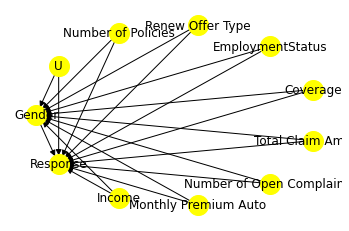

In [39]:
model1= CausalModel(
        data=clv_clean,
        treatment='Gender',
        outcome="Response",
        common_causes=['Income','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Renew Offer Type','Number of Policies'])
model1.view_model()

In [40]:
identified_estimand1 = model1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand1)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
    d                                                                         
─────────(Expectation(Response|Coverage,Monthly Premium Auto,Renew Offer Type,
d[Gender]                                                                     

                                                                              
Total Claim Amount,Number of Open Complaints,EmploymentStatus,Number of Polici
                                                                              

           
es,Income))
           
Estimand assumption 1, Unconfoundedness: If U→{Gender} and U→Response then P(Response|Gender,Coverage,Monthly Premium Auto,Renew Offer Type,Total Claim Amount,Number of Open Complaints,EmploymentStatus,Number of Policies,Income,U) = P(Response|Gender,Coverage,Monthly Premium Auto,Renew Offer Type,Total Claim Amount,Number of Open Complaints,EmploymentStatus,Number of Policies,In

In [41]:
causal_estimate1 = model1.estimate_effect(identified_estimand1,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate1)
print("Causal Estimate is " + str(causal_estimate1.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Response~Gender+Coverage+Monthly Premium Auto+Renew Offer Type+Total Claim Amount+Number of Open Complaints+EmploymentStatus+Number of Policies+Income


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Gender+Coverage+Monthly Premium Auto+Renew Offer Type+Total Claim Amount+Number of Open Complaints+EmploymentStatus+Number of Policies+Income
Target units: ate

## Estimate
Mean value: 0.001794487864560961

Causal Estimate is 0.001794487864560961


C:\Users\Nupur\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nupur\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


**Treatment - Income**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Income'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


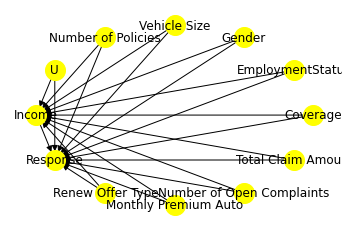

In [42]:
model2= CausalModel(
        data=clv_clean,
        treatment='Income',
        outcome="Response",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies'])
model2.view_model()

In [43]:
identified_estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand2)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
    d                                                                         
─────────(Expectation(Response|Coverage,Monthly Premium Auto,Renew Offer Type,
d[Income]                                                                     

                                                                              
Gender,Total Claim Amount,Number of Open Complaints,EmploymentStatus,Number of
                                                                              

                        
 Policies,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{Income} and U→Response then P(Response|Income,Coverage,Monthly Premium Auto,Renew Offer Type,Gender,Total Claim Amount,Number of Open Complaints,EmploymentStatus,Number of Policies,Vehicle Size,U) = P(Response|Income,Coverage,Monthly Premium Auto,Renew Offer Type,Gender,Total Claim Amount,Numbe

In [44]:
causal_estimate2 = model2.estimate_effect(identified_estimand2,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate2)
print("Causal Estimate is " + str(causal_estimate2.value))

INFO:dowhy.causal_estimator:b: Response~Income+Coverage+Monthly Premium Auto+Renew Offer Type+Gender+Total Claim Amount+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Income+Coverage+Monthly Premium Auto+Renew Offer Type+Gender+Total Claim Amount+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
Target units: ate

## Estimate
Mean value: 2.761591893496451e-07
p-value: [0.03149929]

Causal Estimate is 2.761591893496451e-07


**Treatment - Monthly Premium Auto**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Monthly Premium Auto'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


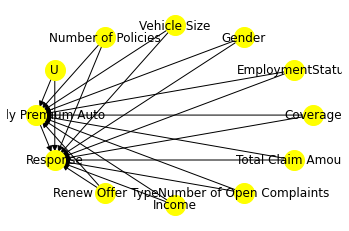

In [45]:
model3= CausalModel(
        data=clv_clean,
        treatment='Monthly Premium Auto',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies'])
model3.view_model()

In [46]:
identified_estimand3 = model3.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand3)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
           d                                                                  
───────────────────────(Expectation(Response|Coverage,Renew Offer Type,Gender,
d[Monthly Premium Auto]                                                       

                                                                              
Total Claim Amount,Income,Number of Open Complaints,EmploymentStatus,Number of
                                                                              

                        
 Policies,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{Monthly Premium Auto} and U→Response then P(Response|Monthly Premium Auto,Coverage,Renew Offer Type,Gender,Total Claim Amount,Income,Number of Open Complaints,EmploymentStatus,Number of Policies,Vehicle Size,U) = P(Response|Monthly Premium Auto,Coverage,Renew Offer Type,Gender,Total Claim Amoun

In [47]:
causal_estimate3 = model3.estimate_effect(identified_estimand3,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate3)
print("Causal Estimate is " + str(causal_estimate3.value))

INFO:dowhy.causal_estimator:b: Response~Monthly Premium Auto+Coverage+Renew Offer Type+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Monthly Premium Auto+Coverage+Renew Offer Type+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
Target units: ate

## Estimate
Mean value: 0.00016161019004101718
p-value: [0.26023053]

Causal Estimate is 0.00016161019004101718


**Treatment - Number of Open Complaints**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Number of Open Complaints'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


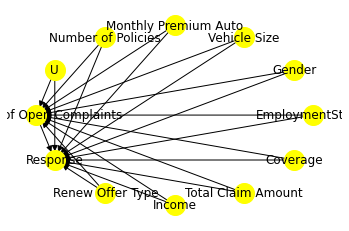

In [48]:
model5= CausalModel(
        data=clv_clean,
        treatment='Number of Open Complaints',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Monthly Premium Auto','Number of Policies'])
model5.view_model()

In [49]:
identified_estimand5 = model5.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand5)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
             d                                                                
────────────────────────────(Expectation(Response|Coverage,Renew Offer Type,Mo
d[Number of Open Complaints]                                                  

                                                                              
nthly Premium Auto,Gender,Total Claim Amount,Income,EmploymentStatus,Number of
                                                                              

                        
 Policies,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{Number of Open Complaints} and U→Response then P(Response|Number of Open Complaints,Coverage,Renew Offer Type,Monthly Premium Auto,Gender,Total Claim Amount,Income,EmploymentStatus,Number of Policies,Vehicle Size,U) = P(Response|Number of Open Complaints,Coverage,Renew Offer Type,Monthly Premiu

In [50]:
causal_estimate5 = model5.estimate_effect(identified_estimand5,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate5)
print("Causal Estimate is " + str(causal_estimate5.value))

INFO:dowhy.causal_estimator:b: Response~Number of Open Complaints+Coverage+Renew Offer Type+Monthly Premium Auto+Gender+Total Claim Amount+Income+EmploymentStatus+Number of Policies+Vehicle Size
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Number of Open Complaints+Coverage+Renew Offer Type+Monthly Premium Auto+Gender+Total Claim Amount+Income+EmploymentStatus+Number of Policies+Vehicle Size
Target units: ate

## Estimate
Mean value: -0.0007171882947570318
p-value: [0.84939671]

Causal Estimate is -0.0007171882947570318


**Treatment - Number of Policies**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Number of Policies'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


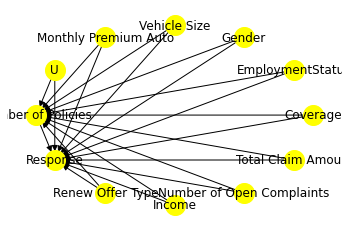

In [51]:
model6= CausalModel(
        data=clv_clean,
        treatment='Number of Policies',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Monthly Premium Auto'])
model6.view_model()

In [52]:
identified_estimand6 = model6.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand6)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
          d                                                                   
─────────────────────(Expectation(Response|Coverage,Renew Offer Type,Monthly P
d[Number of Policies]                                                         

                                                                              
remium Auto,Gender,Total Claim Amount,Income,Number of Open Complaints,Employm
                                                                              

                        
entStatus,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{Number of Policies} and U→Response then P(Response|Number of Policies,Coverage,Renew Offer Type,Monthly Premium Auto,Gender,Total Claim Amount,Income,Number of Open Complaints,EmploymentStatus,Vehicle Size,U) = P(Response|Number of Policies,Coverage,Renew Offer Type,Monthly Premium Auto,Gender,

In [53]:
causal_estimate6 = model6.estimate_effect(identified_estimand6,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate6)
print("Causal Estimate is " + str(causal_estimate6.value))

INFO:dowhy.causal_estimator:b: Response~Number of Policies+Coverage+Renew Offer Type+Monthly Premium Auto+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Number of Policies+Coverage+Renew Offer Type+Monthly Premium Auto+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size
Target units: ate

## Estimate
Mean value: -0.0006524961648662897
p-value: [0.65021955]

Causal Estimate is -0.0006524961648662897


**Treatment - Total Claim Amount**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Total Claim Amount'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


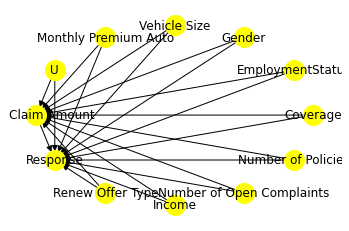

In [54]:
model7= CausalModel(
        data=clv_clean,
        treatment='Total Claim Amount',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Number of Open Complaints','Number of Policies','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Monthly Premium Auto'])
model7.view_model()

In [55]:
identified_estimand7 = model7.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand7)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
          d                                                                   
─────────────────────(Expectation(Response|Coverage,Renew Offer Type,Monthly P
d[Total Claim Amount]                                                         

                                                                              
remium Auto,Gender,Income,Number of Open Complaints,EmploymentStatus,Number of
                                                                              

                        
 Policies,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{Total Claim Amount} and U→Response then P(Response|Total Claim Amount,Coverage,Renew Offer Type,Monthly Premium Auto,Gender,Income,Number of Open Complaints,EmploymentStatus,Number of Policies,Vehicle Size,U) = P(Response|Total Claim Amount,Coverage,Renew Offer Type,Monthly Premium Auto,Gender,

In [57]:
causal_estimate7 = model7.estimate_effect(identified_estimand7,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate7)
print("Causal Estimate is " + str(causal_estimate7.value))

INFO:dowhy.causal_estimator:b: Response~Total Claim Amount+Coverage+Renew Offer Type+Monthly Premium Auto+Gender+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Total Claim Amount+Coverage+Renew Offer Type+Monthly Premium Auto+Gender+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
Target units: ate

## Estimate
Mean value: 2.5645605327972998e-05
p-value: [0.13826636]

Causal Estimate is 2.5645605327972998e-05


**Treatment - EmploymentStatus-Retired vs Others**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['EmploymentStatus'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


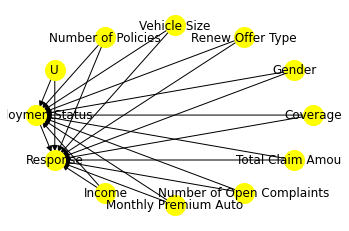

In [58]:
model8= CausalModel(
        data=clv_clean,
        treatment='EmploymentStatus',
        outcome="Response",
        common_causes=['Income','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','Gender',
                      'Renew Offer Type','Vehicle Size','Number of Policies'])
model8.view_model()

In [59]:
identified_estimand8 = model8.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand8)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Response|Coverage,Monthly Premium Auto,Renew O
d[EmploymentStatus]                                                           

                                                                              
ffer Type,Gender,Total Claim Amount,Income,Number of Open Complaints,Number of
                                                                              

                        
 Policies,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{EmploymentStatus} and U→Response then P(Response|EmploymentStatus,Coverage,Monthly Premium Auto,Renew Offer Type,Gender,Total Claim Amount,Income,Number of Open Complaints,Number of Policies,Vehicle Size,U) = P(Response|EmploymentStatus,Coverage,Monthly Premium Auto,Renew Offer Type,Gender,Tota

In [60]:
causal_estimate8 = model8.estimate_effect(identified_estimand8,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate8)
print("Causal Estimate is " + str(causal_estimate8.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Response~EmploymentStatus+Coverage+Monthly Premium Auto+Renew Offer Type+Gender+Total Claim Amount+Income+Number of Open Complaints+Number of Policies+Vehicle Size
C:\Users\Nupur\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nupur\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~EmploymentStatus+Coverage+Monthly Premium Auto+Renew Offer Type+Gender+Total Claim Amount+Income+Number of Open Complaints+Number of Policies+Vehicle Size
Target units: ate

## Estimate
Mean value: 0.6865826321132407

Causal Estimate is 0.6865826321132407


**Treatment - Renew Offer Type- Offer2 vs Others**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Renew Offer Type'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


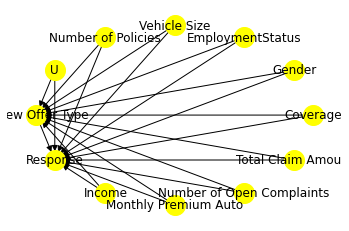

In [61]:
model9= CausalModel(
        data=clv_clean,
        treatment='Renew Offer Type',
        outcome="Response",
        common_causes=['Income','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','Gender',
                      'EmploymentStatus','Vehicle Size','Number of Policies'])
model9.view_model()

In [62]:
identified_estimand9 = model9.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand9)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Response|Coverage,Monthly Premium Auto,Gender,
d[Renew Offer Type]                                                           

                                                                              
Total Claim Amount,Income,Number of Open Complaints,EmploymentStatus,Number of
                                                                              

                        
 Policies,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{Renew Offer Type} and U→Response then P(Response|Renew Offer Type,Coverage,Monthly Premium Auto,Gender,Total Claim Amount,Income,Number of Open Complaints,EmploymentStatus,Number of Policies,Vehicle Size,U) = P(Response|Renew Offer Type,Coverage,Monthly Premium Auto,Gender,Total Claim Amount,In

In [63]:
causal_estimate9 = model9.estimate_effect(identified_estimand9,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate9)
print("Causal Estimate is " + str(causal_estimate9.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Response~Renew Offer Type+Coverage+Monthly Premium Auto+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Renew Offer Type+Coverage+Monthly Premium Auto+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
Target units: ate

## Estimate
Mean value: 0.1197022780411956

Causal Estimate is 0.1197022780411956


C:\Users\Nupur\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nupur\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Coverage'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


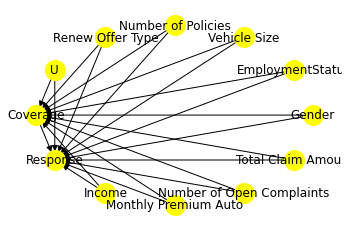

In [65]:
model10= CausalModel(
        data=clv_clean,
        treatment='Coverage',
        outcome="Response",
        common_causes=['Income','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','Gender',
                      'EmploymentStatus','Vehicle Size','Number of Policies','Renew Offer Type'])
model10.view_model()

In [66]:
identified_estimand10 = model10.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand10)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                                        
───────────(Expectation(Response|Monthly Premium Auto,Renew Offer Type,Gender,
d[Coverage]                                                                   

                                                                              
Total Claim Amount,Income,Number of Open Complaints,EmploymentStatus,Number of
                                                                              

                        
 Policies,Vehicle Size))
                        
Estimand assumption 1, Unconfoundedness: If U→{Coverage} and U→Response then P(Response|Coverage,Monthly Premium Auto,Renew Offer Type,Gender,Total Claim Amount,Income,Number of Open Complaints,EmploymentStatus,Number of Policies,Vehicle Size,U) = P(Response|Coverage,Monthly Premium Auto,Renew Offer Type,Gender,Total Claim Amount,Income,Num

In [67]:
causal_estimate10 = model10.estimate_effect(identified_estimand10,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate10)
print("Causal Estimate is " + str(causal_estimate10.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Response~Coverage+Monthly Premium Auto+Renew Offer Type+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Coverage+Monthly Premium Auto+Renew Offer Type+Gender+Total Claim Amount+Income+Number of Open Complaints+EmploymentStatus+Number of Policies+Vehicle Size
Target units: ate

## Estimate
Mean value: 0.003762287744560183

Causal Estimate is 0.003762287744560183


C:\Users\Nupur\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nupur\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
